In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import torchvision.transforms.functional as VF 
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from utils import * 
from torchvision.utils import make_grid
from numba import jit
import os
import pandas as pd, seaborn as sns

In [3]:
def PlotImgGT(img, labels):
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.imshow(img, cmap='gray')
    ax2.imshow(labels, cmap='gray')
    ax1.set_axis_off()
    ax2.set_axis_off()
    return fig

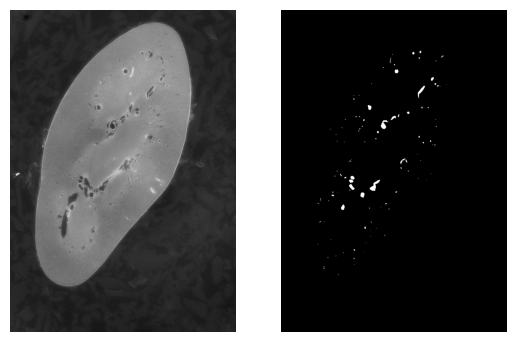

In [4]:
data_dir = os.path.abspath('/media/Storage3.6TB/SenNet-Segmentation/train/kidney_1_dense/')
dirs_train =  [f.path for f in os.scandir("/media/Storage3.6TB/SenNet-Segmentation/train")][2:]
dirs_test = [[f.path for f in os.scandir("/media/Storage3.6TB/SenNet-Segmentation/train")][0]]

img = plt.imread(os.path.join(data_dir, "images", "0413.tif"))
labels = plt.imread(os.path.join(data_dir, "labels", "0413.tif"))

fig1 = PlotImgGT(img, labels)

dataset = ConcatDataset([HiPCTDataset2D(_dir, reshapeSize=(512,512)) for _dir in dirs_train + dirs_test])
dataloader = DataLoader(dataset, shuffle=True, batch_size=9)
dataiter = iter(dataloader)

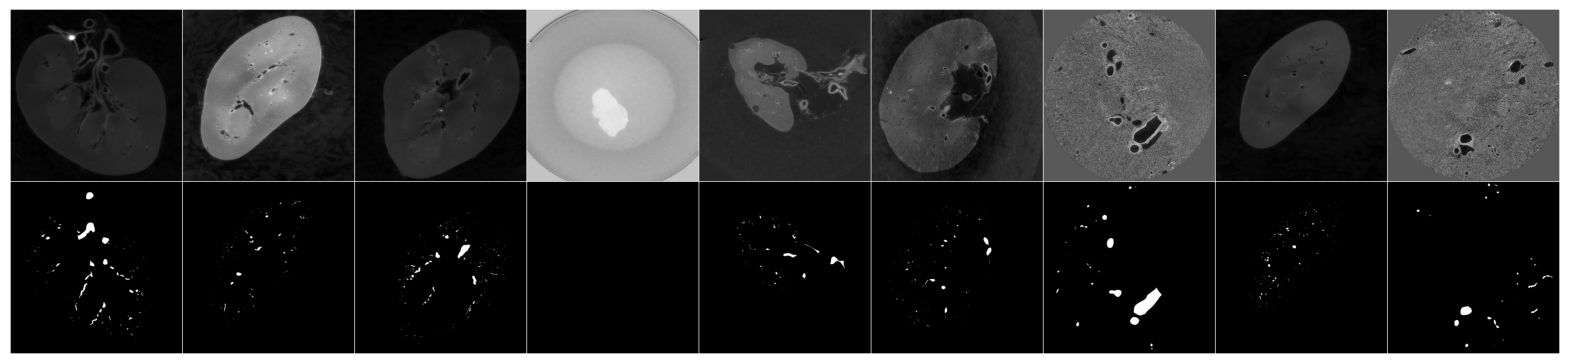

In [5]:
imgs, masks = next(dataiter)

grid = make_grid([*imgs, *masks], nrow=9, pad_value=1).permute(1,2,0)
fig = plt.figure(figsize=(20,20))
plt.imshow(grid)
plt.axis('off')
plt.show()

(512, 512) (512, 512) (16, 128, 128) (4, 4, 128, 128)
img.min()=0.0, img.max()=1.0, reconstructedImg.min()=0.0, reconstructedImg.max()=1.0
(img==reconstructedImg).all()=True


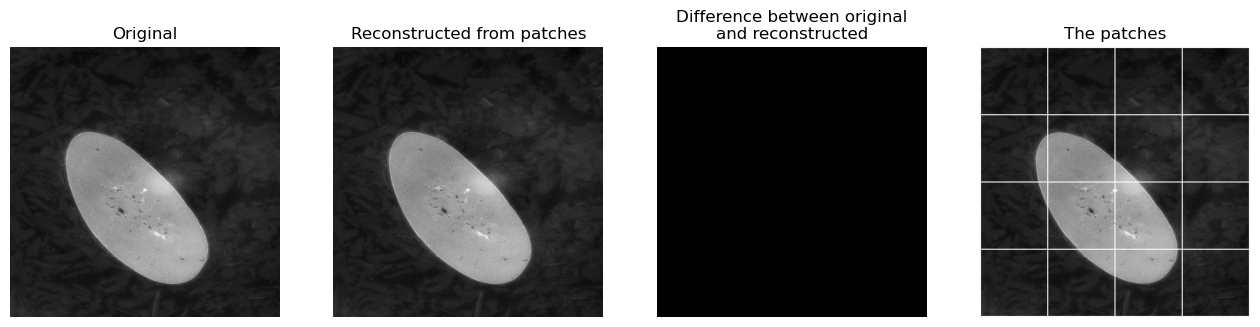

In [6]:
patch_size=128
overlap=0

imgs, masks = next(dataiter)
img = imgs[torch.randint(9, (1,))].squeeze().numpy()
patches, patches_shape = split_image_into_patches(img, patch_size, overlap)
reconstructedImg = reconstruct_image_from_patches(patches.reshape(patches_shape), img.shape[-2:], patch_size, overlap)
print(reconstructedImg.shape, img.shape, patches.shape, patches_shape)
print(f"{img.min()=}, {img.max()=}, {reconstructedImg.min()=}, {reconstructedImg.max()=}")
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(16,4))
ax1.imshow(img, cmap='gray')
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
ax4.set_axis_off()
ax2.imshow(reconstructedImg, cmap='gray')
ax1.set_title('Original')
ax2.set_title("Reconstructed from patches")
ax3.imshow(img-reconstructedImg, cmap='gray')
ax3.set_title("Difference between original\nand reconstructed")
print(f"{(img==reconstructedImg).all()=}")
grid = make_grid(torch.Tensor(patches).unsqueeze(1), nrow=patches_shape[0], pad_value=1).permute(1,2,0)
ax4.imshow(grid)
ax4.set_title("The patches")
plt.show()

In [7]:
df = {}
i = 0 
for d in [os.path.join(d, 'labels') for d in dirs_test+dirs_train]:
    for f in tqdm([f for f in os.scandir(d)]):
        im = plt.imread(f.path)
        ones = int(im.sum()/255)
        zeros = int(im.size-ones)
        df[i] = {0:zeros,1:ones}
        i+=1
df = pd.DataFrame.from_dict(df, orient='index').assign(withResize=False)

 90%|██████████████████████████████████████████████████████████████▎      | 935/1035 [00:20<00:02, 44.97it/s]


KeyboardInterrupt: 

In [ ]:
_df = {}
for _, im in tqdm(dataset):
    ones = int(im.sum()/255)
    zeros = int(im.nelement()-ones)
    _df[i] = {0:zeros,1:ones}
    i+=1
df = pd.concat((df, pd.DataFrame.from_dict(_df, orient='index').assign(withResize=True)), axis=0)

In [ ]:
df['BG/FG Ratio'] = df[1]/df[0]
sns.histplot(data=df, x='BG/FG Ratio', bins=30, hue='withResize', stat='probability')
print(df.mean())

In [ ]:
del df
_df = {}
i = 0 
for patch_size in (64,128):
    for d in [os.path.join(d, 'labels') for d in dirs_test+dirs_train]:
        for f in tqdm([f for f in os.scandir(d)]):
            im = plt.imread(f.path)
            im, _ = split_image_into_patches(im, patch_size, overlap)
            ones = int(im.sum()/255)
            zeros = int(im.size-ones)
            _df[i] = {0:zeros,1:ones}
            i+=1
    try:
        df = pd.concat((df, pd.DataFrame.from_dict(_df, orient='index').assign(patchSize=patch_size)), axis=0)
    except:
        df = pd.DataFrame.from_dict(_df, orient='index').assign(patchSize=patch_size)
df

In [ ]:
df['BG/FG Ratio'] = df[1]/df[0]
sns.histplot(data=df, x='BG/FG Ratio', bins=30, hue='patchSize', stat='probability')
print(df.mean())

In [ ]:
import torch
import torch.nn.functional as nnf

class ShufflePatches(object):
  def __init__(self, patch_size:int, stride:int):
    self.ps = patch_size
    self.st = stride

  def __call__(self, x):
    # # divide the batch of images into non-overlapping patches
    # u = nnf.unfold(x, kernel_size=self.ps, stride=self.ps, padding=0)
    # # permute the patches of each image in the batch
    # pu = torch.cat([b_[:, torch.randperm(b_.shape[-1])][None,...] for b_ in u], dim=0)
    # # fold the permuted patches back together
    # f = nnf.fold(pu, x.shape[-2:], kernel_size=self.ps, stride=self.ps, padding=0)
    patches = x.unfold(2, self.ps, self.st).unfold(3, self.ps, self.st)
    patches = patches.contiguous().view(patches.size(0), -1, self.ps, self.ps)
    # patches = torch.cat([b_[:, torch.randperm(b_.shape[-1])][None,...] for b_ in patches], dim=0)
    return patches

In [ ]:
loader = DataLoader(dataset, batch_size=9)
imgs, preds = next(iter(loader))
print(imgs.shape)
patches = ShufflePatches(128,64)(imgs)
print(patches.shape)
n = int((512 + 0 - 1*(128-1)-1)/64 + 1)**2
patches = patches.reshape(-1,1,128,128)
print(patches.shape)
patches = patches.reshape(-1, n, 128,128)

patches = patches[0]
print(patches.shape)
grid = make_grid(patches.unsqueeze(1), nrow=int(patches.shape[0]**.5))
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.imshow(make_grid(imgs[0]).permute(1,2,0))
ax2.imshow(grid.permute(1,2,0))
ax1.set_axis_off()
ax2.set_axis_off()

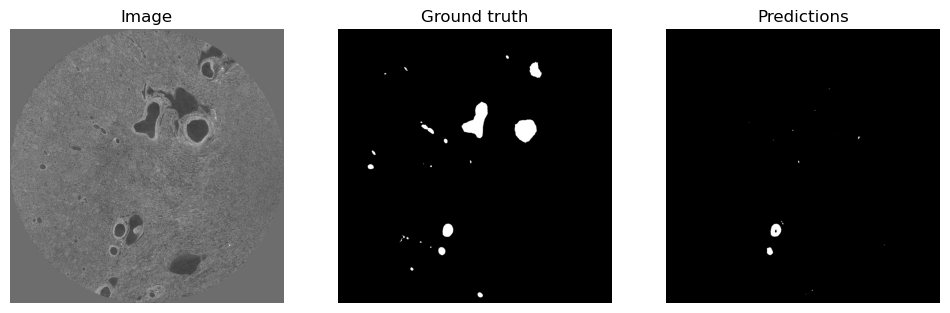

In [1]:
import torch                                                                                                                                                                                                       
import torch.nn as nn                                                                                                                                                                                              
import torchvision.transforms as transforms                                                                                                                                                                        
from torch import optim                                                                                                                                                                                            
from torch.utils.data import DataLoader, Subset, ConcatDataset, Dataset
from torchinfo import summary                                                                                                                                                                                      
from torchvision.utils import make_grid                                                                                                                                                                            
from utils import HiPCTDataset2D_patches                                                                                                                                                                                                
from tqdm import tqdm                                                                                                                                                                                              
import torch.nn.functional as F                                                                                                                                                                                    
import os                         

import matplotlib.pyplot as plt
import numpy as np 
                                                                                                                                                                                                                   
from evaluate import evaluate                                                                                                                                                                                      
from unet_model import UNet                                                                                                                                                                                        
from utils import dice_loss, rle_encode, split_image_into_patches, reconstruct_image_from_patches
from skimage.util import view_as_windows  

batch_size = 1
patch_size = 128
overlap = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

dirs_train =  [f.path for f in os.scandir("/media/Storage3.6TB/SenNet-Segmentation/train")][2:]                                                                                                                    
dirs_test = [[f.path for f in os.scandir("/media/Storage3.6TB/SenNet-Segmentation/train")][0]]                                            

class SimpleDatasetForTesting(Dataset):
    def __init__(self, data_dir, patch_size:int=128):
        self.labels_dir = os.path.abspath(os.path.join(data_dir, 'labels'))                                                                                                                                        
        self.img_dir = os.path.abspath(os.path.join(data_dir, 'images'))        
        self.to_tensor = transforms.ToTensor()
        H, W = plt.imread(os.path.join(self.labels_dir, '0001.tif')).shape
        self.H, self.W = H, W
        # n0, n1 = patch_size - H%patch_size, patch_size - W%patch_size
        n0, n1 = 2048-W, 2048-H
        if n0%2 == 0: 
            n00 = n01 = int(n0/2) 
        else:
            n00 = int(np.floor(n0/2))
            n01 = int(np.floor(n0/2)+1)
        if n1%2 == 0: 
            n10 = n11 = int(n1/2) 
        else:
            n10 = int(np.floor(n1/2))
            n11 = int(np.floor(n1/2) +1)
        self.pad = transforms.Pad(padding=[n00,n10,n01,n11], fill=0)
        self.crop = transforms.Pad(padding=[-n00, -n10, -n01, -n11], fill=0)
            
    def __len__(self):
        return len([f for f in os.listdir(self.img_dir) if os.path.isfile(os.path.join(self.img_dir, f))])
    def __getitem__(self, idx:int):
        img_path = os.path.join(self.img_dir, f"{idx:04d}.tif")
        labels_path = os.path.join(self.labels_dir, f"{idx:04d}.tif")  
        image = self.to_tensor(plt.imread(img_path).astype(float)) 
        labels = (self.to_tensor(plt.imread(labels_path).astype(float))>0.0).to(dtype=torch.float16)  
        image = ((image-image.min())/(image.max()-image.min()))
        return self.pad(image), self.pad(labels)   

def FullImagePred(model, img):
    patches, patches_shape = split_image_into_patches(img, 128, 0)
    patches = torch.Tensor(patches).unsqueeze(1)

    preds = torch.empty(patches.shape)
    #with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=True):
    n=1
    miniBatch = int(patches.shape[0]/n)
    for i in range(n):
        s = slice(i*n, (i+1)*n if i+1!=n else None)
        im = patches[s].to(device)
        preds[s] = model(im).to('cpu')
        del im    
    preds = (preds > 0.5).float().squeeze().numpy()
    reconstructedImg = reconstruct_image_from_patches(preds.reshape(patches_shape), img.shape[-2:], 128, 0)
    return reconstructedImg

#dataset = ConcatDataset([SimpleDataset(d) for d in dirs_test+dirs_train])
dataset = SimpleDatasetForTesting(dirs_train[0])
dataloader = DataLoader(dataset, shuffle=True, batch_size=1)
dataiter = iter(dataloader)
img, labels = next(dataiter)
while labels.sum()==0:
    img, labels = next(dataiter)
img, labels = next(dataiter)

model = UNet(n_channels=1, n_classes=1, bilinear=True)                                                                                                                                                         
model.load_state_dict(torch.load("/home/remi/Desktop/PytorchNaiveModels/SenNet-UNet/runs/Jan9-Resize1024-Stride256-ps256/checkpoint_model_499.pth")) 
model.to(device)
model.eval();

preds = FullImagePred(model, img.squeeze().numpy())
fig, axs = plt.subplots(1,3, figsize=(12,8))

img = dataset.crop(img)
labels = dataset.crop(labels)
preds = dataset.crop(torch.Tensor(preds))

axs[0].imshow(img.squeeze().detach().numpy(), cmap='grey')
axs[1].imshow(labels.squeeze().detach().numpy(), cmap='grey')
axs[2].imshow(preds, cmap='grey')
for ax, title in zip(axs.flat, ['Image','Ground truth', 'Predictions']):
    ax.set_axis_off()
    ax.set_title(title)

In [2]:
for d in dirs_train+dirs_test:
    dataset = SimpleDataset(d)
    dataloader = DataLoader(dataset, shuffle=False, batch_size=1)
    dname = d.split('/')[-1]
    saveDir = "/home/remi/Desktop/PytorchNaiveModels/SenNet-UNet/runs/Jan9-Resize1024-Stride256-ps256/"

    for i, (img, labels) in tqdm(enumerate(dataloader), total = len(dataset), unit='image'): 
        if labels.sum()==0:
            continue
        imName = lambda x: os.path.join(saveDir, x,  dname+f"_{i:04d}.png")
        preds = FullImagePred(model, img.squeeze().numpy())
        # img = dataset.crop(img).squeeze().detach().numpy()
        # labels = dataset.crop(labels).squeeze().detach().numpy()
        preds = dataset.crop(torch.Tensor(preds)).squeeze().detach().numpy()
        
        #plt.imsave(imName("images"), img) # Save in directory "images"
        plt.imsave(imName("groundTruth"), labels) # Save in directory "groundTruth"
        plt.imsave(imName("predictions"), preds) # Save in directory "predictions"


 39%|███▉      | 860/2217 [07:52<13:17,  1.70image/s]

In [ ]:
im, gt = next(iter(dataloader))
preds = (model(im.squeeze(0).to(device, dtype=torch.float32, memory_format=torch.channels_last)) > 0.5)

fig, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].imshow(im.squeeze()[0], cmap='grey')
axs[1].imshow(gt.squeeze()[0], cmap='grey')
axs[2].imshow(preds.squeeze()[0].to('cpu').detach().numpy(), cmap='grey')

RuntimeError: required rank 4 tensor to use channels_last format